# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields with eddy decomposition on OMET with spatial patterns in certain season** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.10.30 ** <br>
** Last Update  : 2018.11.25 ** <br>
Description     : This notebook includes the result of the lag regression of climatological fields (e.g. z500) on OMET. It aims to unveil the relation between the climatological fields and OMET and try to illustrate how the ocean drives the atmosphere through the change of OMET.
Besides, the contribution of stationary eddy and steady mean transport are studied here too.<br>
Return Values   : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2014
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [11]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
    output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_mechanism/OMET/spatial/omet_E_eddy'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_200hPa_eddy = Dataset(os.path.join(datapath_ERAI_fields,
                                        'model_daily_075_E_eddies_200hPa_point.nc'))
    dataset_ERAI_300hPa_eddy = Dataset(os.path.join(datapath_ERAI_fields,
                                        'model_daily_075_E_eddies_300hPa_point.nc'))
    dataset_ERAI_400hPa_eddy = Dataset(os.path.join(datapath_ERAI_fields,
                                        'model_daily_075_E_eddies_400hPa_point.nc'))
    dataset_ERAI_500hPa_eddy = Dataset(os.path.join(datapath_ERAI_fields,
                                        'model_daily_075_E_eddies_500hPa_point.nc'))
    dataset_ERAI_850hPa_eddy = Dataset(os.path.join(datapath_ERAI_fields,
                                        'model_daily_075_E_eddies_850hPa_point.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                 'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # list of variables
    var_book = ['cpT', 'Lvq', 'gz']
    var_op = 0
    # 4D fields [year, month, lat, lon]
    # eddies at certain height
    p200_transient = dataset_ERAI_200hPa_eddy.variables['{}_transient'.format(var_book[var_op])][:-1,:,:,:]
    p200_standing = dataset_ERAI_200hPa_eddy.variables['{}_standing'.format(var_book[var_op])][:-1,:,:,:]
    p300_transient = dataset_ERAI_300hPa_eddy.variables['{}_transient'.format(var_book[var_op])][:-1,:,:,:]
    p300_standing = dataset_ERAI_300hPa_eddy.variables['{}_standing'.format(var_book[var_op])][:-1,:,:,:]
    p400_transient = dataset_ERAI_400hPa_eddy.variables['{}_transient'.format(var_book[var_op])][:-1,:,:,:]
    p400_standing = dataset_ERAI_400hPa_eddy.variables['{}_standing'.format(var_book[var_op])][:-1,:,:,:]
    p500_transient = dataset_ERAI_500hPa_eddy.variables['{}_transient'.format(var_book[var_op])][:-1,:,:,:]
    p500_standing = dataset_ERAI_500hPa_eddy.variables['{}_standing'.format(var_book[var_op])][:-1,:,:,:]
    p850_transient = dataset_ERAI_850hPa_eddy.variables['{}_transient'.format(var_book[var_op])][:-1,:,:,:]
    p850_standing = dataset_ERAI_850hPa_eddy.variables['{}_standing'.format(var_book[var_op])][:-1,:,:,:]
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000  
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    gphiv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['gphiv'][180:,:]
    glamv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['glamv'][180:,:]
    latitude_eddy_ERAI = dataset_ERAI_500hPa_eddy.variables['latitude'][:]
    longitude_eddy_ERAI = dataset_ERAI_500hPa_eddy.variables['longitude'][:]
    mask_ORAS4 = dataset_ORAS4_mask.variables['vmask'][0,0,180:,:]
    # area weighted surface flux
    p200_transient_weight = np.zeros(p500_transient.shape, dtype=float) # unit W
    p200_standing_weight = np.zeros(p500_standing.shape, dtype=float)
    p300_transient_weight = np.zeros(p500_transient.shape, dtype=float) # unit W
    p300_standing_weight = np.zeros(p500_standing.shape, dtype=float)
    p400_transient_weight = np.zeros(p500_transient.shape, dtype=float) # unit W
    p400_standing_weight = np.zeros(p500_standing.shape, dtype=float)
    p500_transient_weight = np.zeros(p500_transient.shape, dtype=float) # unit W
    p500_standing_weight = np.zeros(p500_standing.shape, dtype=float)
    p850_transient_weight = np.zeros(p500_transient.shape, dtype=float) # unit W
    p850_standing_weight = np.zeros(p500_standing.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_eddy_ERAI /
                                            360) / len(longitude_eddy_ERAI) 
    for i in np.arange(len(latitude_eddy_ERAI)):
        # change the unit to terawatt
        p200_transient_weight[:,:,i,:] = p200_transient[:,:,i,:]* dx[i] / dx[-1]
        p200_standing_weight[:,:,i,:] = p200_standing[:,:,i,:]* dx[i] / dx[-1]
        p300_transient_weight[:,:,i,:] = p300_transient[:,:,i,:]* dx[i] / dx[-1]
        p300_standing_weight[:,:,i,:] = p300_standing[:,:,i,:]* dx[i] / dx[-1]
        p400_transient_weight[:,:,i,:] = p400_transient[:,:,i,:]* dx[i] / dx[-1]
        p400_standing_weight[:,:,i,:] = p400_standing[:,:,i,:]* dx[i] / dx[-1]
        p500_transient_weight[:,:,i,:] = p500_transient[:,:,i,:]* dx[i] / dx[-1]
        p500_standing_weight[:,:,i,:] = p500_standing[:,:,i,:]* dx[i] / dx[-1]
        p850_transient_weight[:,:,i,:] = p850_transient[:,:,i,:]* dx[i] / dx[-1]
        p850_standing_weight[:,:,i,:] = p850_standing[:,:,i,:]* dx[i] / dx[-1]

*********************** extract variables *************************


Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [6]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of lead/lag is the opposite to the one defined in the package.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z200 eddy transient + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


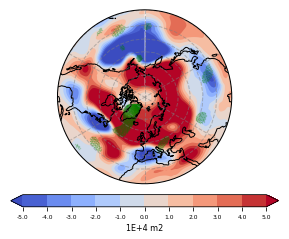

[[25381.19178014 25257.56613396 25123.58458831 24990.95023837
  24854.26513636 24711.35873137 24563.61525602 24410.09768892
  24253.42643821 24093.92754293]
 [30356.65075903 30193.74201401 30018.88871703 29841.7783922
  29656.05896224 29465.74937804 29274.25185202 29074.79772468
  28866.67800288 28655.49075331]
 [35592.11640175 35374.87093025 35156.06016548 34927.00350458
  34687.74929519 34444.54060337 34198.47010474 33937.16204725
  33671.81507748 33404.39300544]
 [40944.13741879 40674.92388862 40397.36290947 40115.22716286
  39816.86538259 39513.26257104 39207.78410815 38887.54505659
  38558.17404937 38226.22874796]
 [46267.3005846  45939.17819817 45615.61913707 45271.35932509
  44920.29443121 44554.23873636 44177.6119129  43793.9658744
  43397.23084667 42995.5045348 ]
 [51454.57863072 51075.69317849 50683.46640764 50276.96946669
  49852.99110388 49418.0173556  48977.79274178 48525.37710653
  48062.80672479 47591.48383011]
 [56403.50835743 55975.82128032 55519.70759548 55048.3523793

In [16]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & p200 eddy transient + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p200_eddy_season_series = meta.statistics.operator.seasons(p200_transient_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p200_eddy_ERAI = meta.statistics.operator(p200_eddy_season_series[3:,:,:])
    stat_p200_eddy_ERAI.anomaly(Dim_month=False)
    stat_p200_eddy_ERAI.detrend()
    stat_p200_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p200_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p200_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p200_eddy_{}_transient_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p200_transient_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z300 eddy transient + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


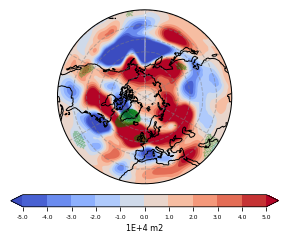

In [17]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & p300 eddy transient + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p300_eddy_season_series = meta.statistics.operator.seasons(p300_transient_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p300_eddy_ERAI = meta.statistics.operator(p300_eddy_season_series[3:,:,:])
    stat_p300_eddy_ERAI.anomaly(Dim_month=False)
    stat_p300_eddy_ERAI.detrend()
    stat_p300_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p300_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p300_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p300_eddy_{}_transient_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p300_transient_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z400 eddy transient + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


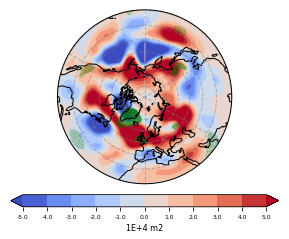

In [18]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & z400 eddy transient + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p400_eddy_season_series = meta.statistics.operator.seasons(p400_transient_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p400_eddy_ERAI = meta.statistics.operator(p400_eddy_season_series[3:,:,:])
    stat_p400_eddy_ERAI.anomaly(Dim_month=False)
    stat_p400_eddy_ERAI.detrend()
    stat_p400_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p400_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p400_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p400_eddy_{}_transient_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p400_transient_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z500 eddy transient + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


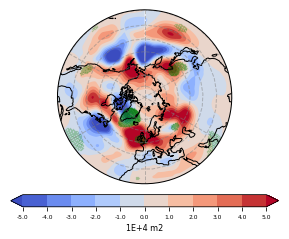

In [19]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & p500 eddy transient + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p500_eddy_season_series = meta.statistics.operator.seasons(p500_transient_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p500_eddy_ERAI = meta.statistics.operator(p500_eddy_season_series[3:,:,:])
    stat_p500_eddy_ERAI.anomaly(Dim_month=False)
    stat_p500_eddy_ERAI.detrend()
    stat_p500_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p500_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p500_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p500_eddy_{}_transient_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p500_transient_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z850 eddy transient + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


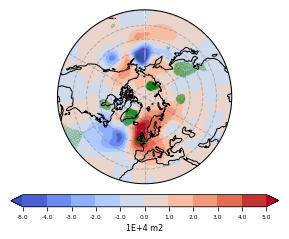

In [20]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & p850 eddy transient + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p850_eddy_season_series = meta.statistics.operator.seasons(p850_transient_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p850_eddy_ERAI = meta.statistics.operator(p850_eddy_season_series[3:,:,:])
    stat_p850_eddy_ERAI.anomaly(Dim_month=False)
    stat_p850_eddy_ERAI.detrend()
    stat_p850_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p850_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p850_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p850_eddy_{}_transient_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p850_transient_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********
===================   z 200 300 400 500 850 eddy transient + winter (DJF)   ===================


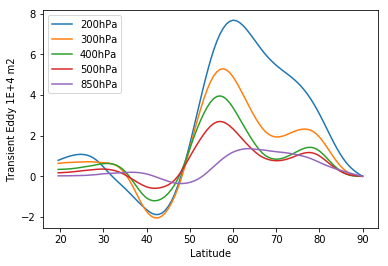

In [22]:
    print ('***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********')
    print ('===================   p 200 300 400 500 850 eddy transient + winter (DJF)   ===================')
    fig = plt.figure()
    plt.plot(latitude_eddy_ERAI, p200_transient_eddy_mean/1E+4, label='200hPa')
    plt.plot(latitude_eddy_ERAI, p300_transient_eddy_mean/1E+4, label='300hPa')
    plt.plot(latitude_eddy_ERAI, p400_transient_eddy_mean/1E+4, label='400hPa')
    plt.plot(latitude_eddy_ERAI, p500_transient_eddy_mean/1E+4, label='500hPa')
    plt.plot(latitude_eddy_ERAI, p850_transient_eddy_mean/1E+4, label='850hPa')
    plt.xlabel("Latitude")
    plt.legend()
    plt.ylabel("Transient Eddy 1E+4 m2")
    plt.show()
    fig.savefig(os.path.join(output_path,'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_eddy_{}_transient_DJF_decadal_mean.png'.format(lag,var_book[var_op])),dpi=400)
    plt.close(fig)

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z200 eddy standing + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


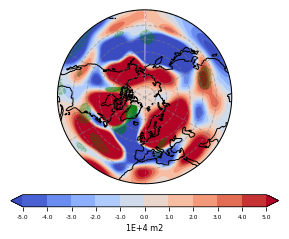

In [24]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & p200 eddy standing + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p200_eddy_season_series = meta.statistics.operator.seasons(p200_standing_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p200_eddy_ERAI = meta.statistics.operator(p200_eddy_season_series[3:,:,:])
    stat_p200_eddy_ERAI.anomaly(Dim_month=False)
    stat_p200_eddy_ERAI.detrend()
    stat_p200_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p200_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p200_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    #label = 'Correlation coefficient'
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p200_eddy_{}_standing_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p200_standing_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z300 eddy standing + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


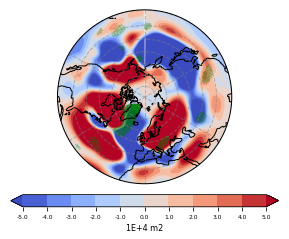

In [25]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & p300 eddy standing + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p300_eddy_season_series = meta.statistics.operator.seasons(p300_standing_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p300_eddy_ERAI = meta.statistics.operator(p300_eddy_season_series[3:,:,:])
    stat_p300_eddy_ERAI.anomaly(Dim_month=False)
    stat_p300_eddy_ERAI.detrend()
    stat_p300_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p300_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p300_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    #label = 'Correlation coefficient'
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p300_eddy_standing_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p300_standing_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z400 eddy standing + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


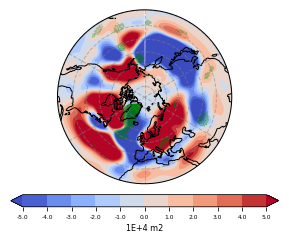

In [26]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & p400 eddy standing + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p400_eddy_season_series = meta.statistics.operator.seasons(p400_standing_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p400_eddy_ERAI = meta.statistics.operator(p400_eddy_season_series[3:,:,:])
    stat_p400_eddy_ERAI.anomaly(Dim_month=False)
    stat_p400_eddy_ERAI.detrend()
    stat_p400_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p400_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p400_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    #label = 'Correlation coefficient'
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p400_eddy_{}_standing_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p400_standing_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z500 eddy standing + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


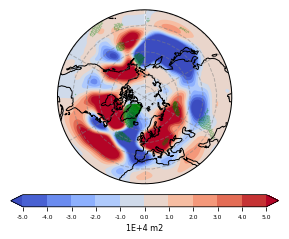

In [27]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & p500 eddy standing + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p500_eddy_season_series = meta.statistics.operator.seasons(p500_standing_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p500_eddy_ERAI = meta.statistics.operator(p500_eddy_season_series[3:,:,:])
    stat_p500_eddy_ERAI.anomaly(Dim_month=False)
    stat_p500_eddy_ERAI.detrend()
    stat_p500_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p500_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p500_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    #label = 'Correlation coefficient'
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p500_eddy_{}_standing_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p500_standing_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z850 eddy standing + winter (DJF)   ===================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


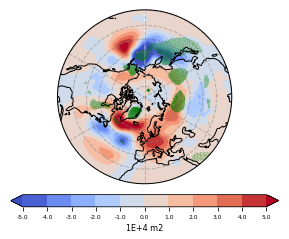

In [28]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & p850 eddy standing + winter (DJF)   ===================')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p850_eddy_season_series = meta.statistics.operator.seasons(p850_standing_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p850_eddy_ERAI = meta.statistics.operator(p850_eddy_season_series[3:,:,:])
    stat_p850_eddy_ERAI.anomaly(Dim_month=False)
    stat_p850_eddy_ERAI.detrend()
    stat_p850_eddy_ERAI.lowpass(window=30, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_p850_eddy_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_p850_eddy_ERAI._detrend)    
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    #label = 'Correlation coefficient'
    ticks = [i for i in np.linspace(-5,5,11)]
    label = '1E+4 m2'
    meta.visualizer.plots.geograph(latitude_eddy_ERAI, longitude_eddy_ERAI, k/1E+4, p_real,
                                   label, ticks, os.path.join(output_path,
                                   'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_p850_eddy_{}_standing_DJF_decadal.png'.format(lag,var_book[var_op])),
                                   ttest=True)
    p850_standing_eddy_mean = np.mean(k,1)
    #print (k[10:20,30:40])

***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********
===================   z 200 300 400 500 850 eddy standing + winter (DJF)   ===================


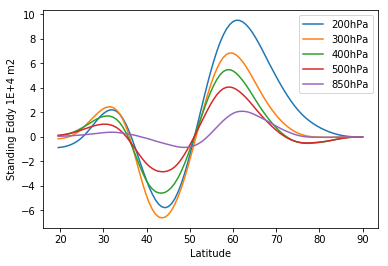

In [29]:
    print ('***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********')
    print ('===================   p 200 300 400 500 850 eddy standing + winter (DJF)   ===================')
    fig = plt.figure()
    plt.plot(latitude_eddy_ERAI, p200_standing_eddy_mean/1E+4, label='200hPa')
    plt.plot(latitude_eddy_ERAI, p300_standing_eddy_mean/1E+4, label='300hPa')
    plt.plot(latitude_eddy_ERAI, p400_standing_eddy_mean/1E+4, label='400hPa')
    plt.plot(latitude_eddy_ERAI, p500_standing_eddy_mean/1E+4, label='500hPa')
    plt.plot(latitude_eddy_ERAI, p850_standing_eddy_mean/1E+4, label='850hPa')
    plt.xlabel("Latitude")
    plt.legend()
    plt.ylabel("Standing Eddy 1E+4 m2")
    plt.show()
    fig.savefig(os.path.join(output_path,'regCoef_ORAS4_atl_OMET_60N_lag_{}_ERAI_eddy_{}_standing_DJF_decadal_mean.png'.format(lag,var_book[var_op])),dpi=400)
    plt.close(fig)

In [ ]:
    print ('***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********')
    print ('===================   z 200 300 400 500 850 eddy transient + winter (DJF)   ===================')
    z200_eddy_season_series = meta.statistics.operator.seasons(z200_transient_weight[:],
                                                               span='DJF', Dim_month=True)
    stat_z200_eddy_ERAI = meta.statistics.operator(z200_eddy_season_series[3:,:,:])
    stat_z200_eddy_ERAI.anomaly(Dim_month=False)
    stat_z200_eddy_ERAI.detrend()
    # z 300 transient
    z300_eddy_season_series = meta.statistics.operator.seasons(z300_standing_weight[:],
                                                               span='DJF', Dim_month=True)
    stat_z300_eddy_ERAI = meta.statistics.operator(z300_eddy_season_series[3:,:,:])
    stat_z300_eddy_ERAI.anomaly(Dim_month=False)
    stat_z300_eddy_ERAI.detrend()
    # z 400 transient
    z400_eddy_season_series = meta.statistics.operator.seasons(z400_standing_weight[:],
                                                               span='DJF', Dim_month=True)
    stat_z400_eddy_ERAI = meta.statistics.operator(z400_eddy_season_series[3:,:,:])
    stat_z400_eddy_ERAI.anomaly(Dim_month=False)
    stat_z400_eddy_ERAI.detrend()
    # z 500 transient
    z500_eddy_season_series = meta.statistics.operator.seasons(z500_standing_weight[:],
                                                               span='DJF', Dim_month=True)
    stat_z500_eddy_ERAI = meta.statistics.operator(z500_eddy_season_series[3:,:,:])
    stat_z500_eddy_ERAI.anomaly(Dim_month=False)
    stat_z500_eddy_ERAI.detrend()
    # z 850 transient
    z850_eddy_season_series = meta.statistics.operator.seasons(z850_standing_weight[:],
                                                               span='DJF', Dim_month=True)
    stat_z850_eddy_ERAI = meta.statistics.operator(z850_eddy_season_series[3:,:,:])
    stat_z850_eddy_ERAI.anomaly(Dim_month=False)
    stat_z850_eddy_ERAI.detrend()

In [ ]:
    print ('***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********')
    print ('===================   z 200 300 400 500 850 eddy standing + winter (DJF)   ===================')
    lag = 2